In [1]:
import pandas as pd
import rdkit
import numpy as np
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

/projects/rlmolecule/pstjohn/envs/tf2_gpu/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
radicals = pd.read_csv('q2_rl_milestone/radicals.csv.gz')

In [3]:
import psycopg2

with psycopg2.connect(**config.dbparams) as conn:
    rew_df = pd.read_sql_query("select * from stablepsj_reward", conn)

In [4]:
import sys
sys.path.append('/home/pstjohn/Packages')

from molcomplex import get_sa_score

from molcomplex.metrics.standalone_model_numpy import SCScorer
model = SCScorer()
model.restore()

Restored variables from /home/pstjohn/Packages/molcomplex/models/full_reaxys_model_1024bool/model.ckpt-10654.as_numpy.json.gz


In [5]:
radical_subset = radicals.sample(2000, random_state=1)
radical_subset['mol'] = radical_subset['0'].progress_apply(rdkit.Chem.MolFromSmiles)
radical_subset['sa_score'] = get_sa_score(radical_subset['mol'])

100%|██████████| 2000/2000 [00:00<00:00, 19496.65it/s]


In [6]:
reward_subset = rew_df.sample(500)
reward_subset['mol'] = reward_subset['smiles'].progress_apply(rdkit.Chem.MolFromSmiles)
reward_subset['sa_score'] = get_sa_score(reward_subset['mol'])

100%|██████████| 500/500 [00:00<00:00, 19185.01it/s]


Text(0.5, 0, 'SA Score')

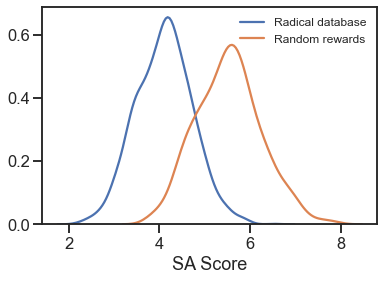

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)

sns.kdeplot(radical_subset['sa_score'], ax=ax, label='Radical database')
sns.kdeplot(reward_subset['sa_score'], ax=ax, label='Random rewards')

ax.legend_.remove()
ax.legend(loc='upper right', fontsize=12)
ax.set_xlabel('SA Score')

In [8]:
radical_subset['sc_score'] = radical_subset['0'].progress_apply(lambda x: model.get_score_from_smi(x)[1])
reward_subset['sc_score'] = reward_subset['smiles'].progress_apply(lambda x: model.get_score_from_smi(x)[1])

100%|██████████| 500/500 [00:09<00:00, 54.38it/s]


Text(0.5, 0, 'SC Score')

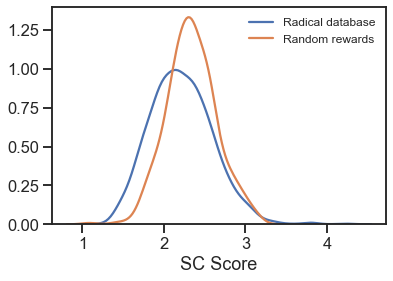

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111)

sns.kdeplot(radical_subset['sc_score'], ax=ax, label='Radical database')
sns.kdeplot(reward_subset['sc_score'], ax=ax, label='Random rewards')

ax.legend_.remove()
ax.legend(loc='upper right', fontsize=12)
ax.set_xlabel('SC Score')

Text(0.5, 0, 'SC Score')

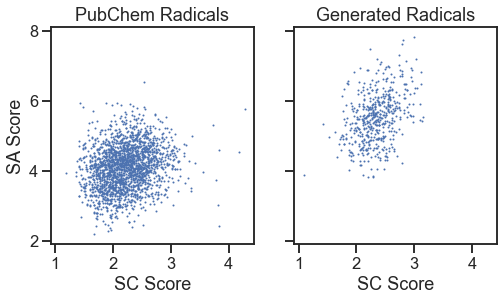

In [10]:
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8,4))

axs[0].set_title('PubChem Radicals')
axs[0].plot(radical_subset['sc_score'], radical_subset['sa_score'], '.', ms=2)

axs[1].set_title('Generated Radicals')
axs[1].plot(reward_subset['sc_score'], reward_subset['sa_score'], '.', ms=2)

axs[0].set_ylabel('SA Score')
axs[0].set_xlabel('SC Score')
axs[1].set_xlabel('SC Score')

In [18]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
from IPython.display import SVG


def plot_smiles(smiles):
    d2d = rdMolDraw2D.MolDraw2DSVG(750, 150, 150, 150)

    mols = [Chem.MolFromSmiles(x) for x in smiles]
    for mol in mols:
        rdMolDraw2D.PrepareMolForDrawing(mol)

    d2d.DrawMolecules(mols, legends=list(smiles))
    d2d.FinishDrawing()
    return SVG(d2d.GetDrawingText())    

# PubChem Radicals

### Lowest SA score

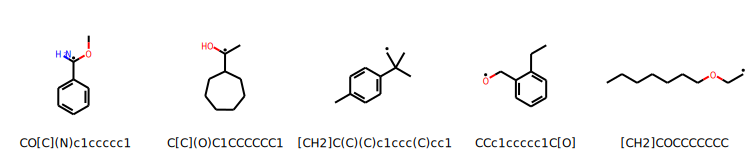

In [19]:
plot_smiles(radical_subset.sort_values('sa_score').head()['0'])

### Highest SA score

362999                     N[C@@H]1C=[C]CC1
138459                 C[C@H]1O[P]O[C@@H]1C
237801      [CH2][C@@H]1O[S@@](=O)O[C@@H]1C
348158           N[C]1C2C[C@@H]3C1[C@@H]3C2
28517     C[C@@]1(C#N)C[C@H]2C=[C][C@@H]1C2
Name: 0, dtype: object


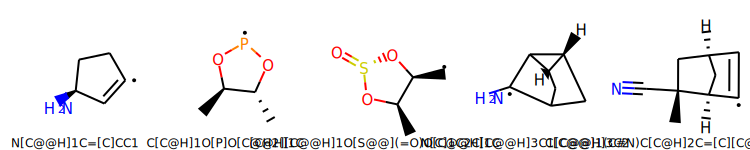

In [22]:
print(radical_subset.sort_values('sa_score').tail()['0'])
plot_smiles(radical_subset.sort_values('sa_score').tail()['0'])

### Lowest SC score

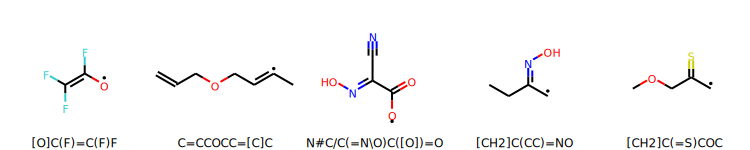

In [23]:
plot_smiles(radical_subset.sort_values('sc_score').head()['0'])

### Highest SC score

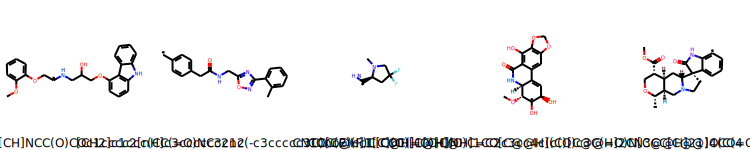

In [24]:
plot_smiles(radical_subset.sort_values('sc_score').tail()['0'])

# Generated Radicals

### Lowest SA score

N=[C]C(=C(O)O)c1cc1=O
CCC(CCO)=C(C)[C]=O
[CH]=C1C=CC(=O)C=C1
C=[C]CC
CCNC(=O)C(=C=[N])C#N


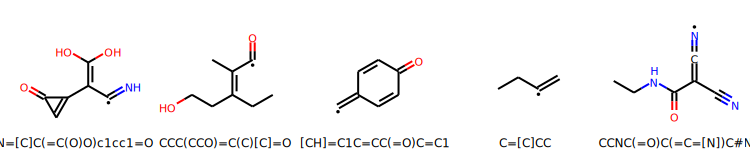

In [33]:
print('\n'.join(reward_subset.sort_values('sa_score').head()['smiles']))
plot_smiles(reward_subset.sort_values('sa_score').head()['smiles'])

### Highest SA score

[C]1=CC2=C3C#CC2=C1C3
[C]1=C=CC=C2C3=C=C2N13
O=C1C2=C=NC3=[C]C13N2
[C]1=C=C2C#CN=C1OO2
NC12[C]=C3OC1C3=C=NO2


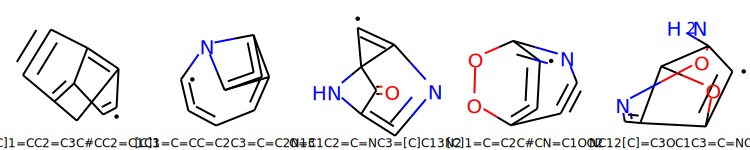

In [34]:
print('\n'.join(reward_subset.sort_values('sa_score').tail()['smiles']))
plot_smiles(reward_subset.sort_values('sa_score').tail()['smiles'])

### Lowest SC score

C=[C]CC
C[C]=C=C=O
C#CC(O)(O)[C]=N
C=[C]OC1=NN1C
[N]=C1C=C(O)O1


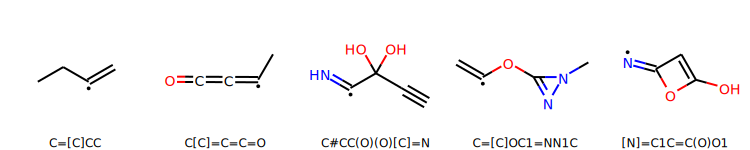

In [35]:
print('\n'.join(reward_subset.sort_values('sc_score').head()['smiles']))
plot_smiles(reward_subset.sort_values('sc_score').head()['smiles'])

### Highest SC score

[CH]=CC=C1N=C1C1=C=C=N1
O=C1[C]=C2CC3=C=C2N3C1
C=NC1=C2[C]=C1ON(C)N2
[CH]=NON1C(=O)N=C1N=C
CC=C1C(OC)=[C]C2=C=C21


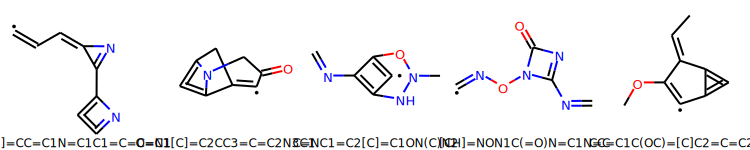

In [36]:
print('\n'.join(reward_subset.sort_values('sc_score').tail()['smiles']))
plot_smiles(reward_subset.sort_values('sc_score').tail()['smiles'])

In [43]:
from rdkit.Chem import AllChem

In [50]:
def get_min_energy(smiles):

    mol = rdkit.Chem.MolFromSmiles(smiles)
    mol = Chem.rdmolops.AddHs(mol)

    is_radical = False
    radical_index = None
    for i, atom in enumerate(mol.GetAtoms()):
        if atom.GetNumRadicalElectrons() != 0:
            is_radical = True
            radical_index = i

            atom.SetNumExplicitHs(atom.GetNumExplicitHs() + 1)
            atom.SetNumRadicalElectrons(0)

    NumRotatableBonds = AllChem.CalcNumRotatableBonds(mol)
    NumConformers = np.clip(3**NumRotatableBonds, 100, 1000)

    conformers = AllChem.EmbedMultipleConfs(
        mol, numConfs=int(NumConformers), pruneRmsThresh=0.2, randomSeed=1,
        useExpTorsionAnglePrefs=True, useBasicKnowledge=True)

    def optimize_conformer(conformer):
        prop = AllChem.MMFFGetMoleculeProperties(mol, mmffVariant="MMFF94s")
        ff = AllChem.MMFFGetMoleculeForceField(mol, prop, confId=conformer)
        ff.Minimize()
        return float(ff.CalcEnergy())

    assert conformers, "Conformer embedding failed"

    conformer_energies = np.array(
        [optimize_conformer(conformer) for conformer in conformers])
    return conformer_energies.min(), mol.GetNumBonds()

In [51]:
get_min_energy('[CH]=CC=C1N=C1C1=C=C=N1')

(450.67919012706125, 14)

In [52]:
get_min_energy('[C]1=CC2=C3C#CC2=C1C3')

AssertionError: Conformer embedding failed

In [2]:
from rdkit import Chem
from rdkit.Chem.rdDistGeom import EmbedMolecule

In [14]:
mol = Chem.MolFromSmiles('[C]1=CC2=C3C#CC2=C1C3')

In [15]:
molH = Chem.AddHs(mol)
EmbedMolecule(molH)

-1

In [49]:
conformer_energies

array([190.87119437, 190.77522675])